In [ ]:
!conda install -y -c conda-forge opencv

In [ ]:
!pip install opencv-python-headless

In [ ]:
import cv2
print(cv2.__version__)

# Creates two masks for instance Seg
- Has binary masks
- Multiple masks for multiple Instances

In [ ]:
import cv2
import numpy as np
import json
import os

# Function to create binary mask from a single bounding box using OpenCV
def create_binary_mask(width, height, bbox):
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.rectangle(mask, (bbox['xmin'], bbox['ymin']), (bbox['xmax'], bbox['ymax']), 1, -1)  # Draw filled rectangle
    return mask

# Load JSON data from file
json_file_path = r'C:\Users\Senbuu\Downloads\hyper-kvasir-segmented-images\segmented-images\bounding-boxes.json'  # Replace with your actual file path

with open(json_file_path, 'r') as file:
    data = json.load(file)

# Create a directory to save the masks
output_dir = r'C:\Users\Senbuu\Downloads\hyper-kvasir-segmented-images\segmented-images\instance_masks'
os.makedirs(output_dir, exist_ok=True)

# Iterate through each image in the JSON data
for image_id, image_data in data.items():
    image_width = image_data['width']
    image_height = image_data['height']
    bboxes = image_data['bbox']
    
    # Create and save a separate mask for each bounding box
    for idx, bbox in enumerate(bboxes):
        binary_mask = create_binary_mask(image_width, image_height, bbox)
        
        # Save the mask as an image with a unique filename
        mask_image_filename = os.path.join(output_dir, f'{image_id}_mask_{idx}.png')
        cv2.imwrite(mask_image_filename, binary_mask * 255)

# Display the saved masks for verification
import matplotlib.pyplot as plt
import glob

mask_files = glob.glob(os.path.join(output_dir, '*.png'))
print("Mask Created Sucessfully")
# for mask_file in mask_files:
#     mask = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
#     plt.figure()
#     plt.title(os.path.basename(mask_file))
#     plt.imshow(mask, cmap='gray')
#     plt.show()


# Combining Both Masks
Test to Combine both masks

In [52]:
import os
import numpy as np
import cv2
import json

def combine_instance_and_semantic_masks(instance_masks_dir, semantic_masks_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    annotations = []

    for instance_mask_file in os.listdir(instance_masks_dir):
        if not instance_mask_file.endswith('.png'):
            continue
        
        image_id = os.path.splitext(instance_mask_file)[0].split('_')[0]  # Extract image ID from instance mask file name
        
        instance_mask_path = os.path.join(instance_masks_dir, instance_mask_file)
        semantic_mask_file = f"{image_id}.jpg"  # Assuming semantic masks are named with image ID + .jpg
        semantic_mask_path = os.path.join(semantic_masks_dir, semantic_mask_file)

        # Load instance mask
        instance_mask = cv2.imread(instance_mask_path, cv2.IMREAD_GRAYSCALE)
        if instance_mask is None:
            print(f"Error: Unable to load instance mask {instance_mask_path}")
            continue

        # Load semantic mask
        semantic_mask = cv2.imread(semantic_mask_path, cv2.IMREAD_GRAYSCALE)
        if semantic_mask is None:
            print(f"Error: Unable to load semantic mask {semantic_mask_path}")
            continue

        # Initialize panoptic mask and segment info
        panoptic_mask = np.zeros_like(instance_mask, dtype=np.uint8)
        segment_info = []
        instance_id = 1

        # Iterate over each unique instance ID in instance mask
        unique_instance_ids = np.unique(instance_mask)
        for unique_id in unique_instance_ids:
            if unique_id == 0:
                continue
            
            # Create mask for this unique instance ID
            mask = instance_mask == unique_id
            
            # Determine category ID from semantic mask (assuming RGB color matching)
            category_id = int(np.unique(semantic_mask[mask])[0])  # Access the first element as a scalar
            
            # Fill panoptic mask with instance ID
            panoptic_mask[mask] = instance_id
            
            # Calculate bounding box coordinates
            bbox = [
                np.min(np.where(mask)[1]),   # xmin
                np.min(np.where(mask)[0]),   # ymin
                np.max(np.where(mask)[1]) - np.min(np.where(mask)[1]),  # width
                np.max(np.where(mask)[0]) - np.min(np.where(mask)[0])   # height
            ]

            # Append segment info for this instance
            segment_info.append({
                "id": instance_id,
                "category_id": category_id,
                "area": int(np.sum(mask)),
                "bbox": list(map(int, bbox)),
                "iscrowd": 0
            })

            instance_id += 1
        
        # Save panoptic mask
        output_path = os.path.join(output_dir, f"{image_id}_panoptic.png")
        cv2.imwrite(output_path, panoptic_mask.astype(np.uint8))

        # Append annotation for this image to annotations list
        annotations.append({
            "image_id": image_id,
            "file_name": f"{image_id}_panoptic.png",
            "segments_info": segment_info
        })

    # Save annotations as JSON
    json_output_file = os.path.join(output_dir, "annotations.json")
    with open(json_output_file, 'w') as f:
        json.dump(annotations, f, indent=4)

    return annotations

# Example usage
annotations = combine_instance_and_semantic_masks(
    instance_masks_dir=r'C:\Users\Senbuu\Downloads\hyper-kvasir-segmented-images\segmented-images\instance_masks',
    semantic_masks_dir=r'C:\Users\Senbuu\Downloads\hyper-kvasir-segmented-images\segmented-images\masks',
    output_dir=r'C:\Users\Senbuu\Downloads\hyper-kvasir-segmented-images\segmented-images\panoptic_masks'
)

print("Panoptic annotations:", annotations)


Panoptic annotations: [{'image_id': '0004a718-546c-41c2-9c69-c4685093a039', 'file_name': '0004a718-546c-41c2-9c69-c4685093a039_panoptic.png', 'segments_info': [{'id': 1, 'category_id': 0, 'area': 63111, 'bbox': [262, 0, 192, 326], 'iscrowd': 0}]}, {'image_id': '0017b7c7-90f8-4de2-8723-1d87e5c58317', 'file_name': '0017b7c7-90f8-4de2-8723-1d87e5c58317_panoptic.png', 'segments_info': [{'id': 1, 'category_id': 0, 'area': 26718, 'bbox': [168, 0, 218, 121], 'iscrowd': 0}]}, {'image_id': '0017b7c7-90f8-4de2-8723-1d87e5c58317', 'file_name': '0017b7c7-90f8-4de2-8723-1d87e5c58317_panoptic.png', 'segments_info': [{'id': 1, 'category_id': 0, 'area': 14823, 'bbox': [375, 100, 80, 182], 'iscrowd': 0}]}, {'image_id': '0017b7c7-90f8-4de2-8723-1d87e5c58317', 'file_name': '0017b7c7-90f8-4de2-8723-1d87e5c58317_panoptic.png', 'segments_info': [{'id': 1, 'category_id': 0, 'area': 6141, 'bbox': [242, 316, 88, 68], 'iscrowd': 0}]}, {'image_id': '0048d8c5-b59d-461c-9834-f44a727e191d', 'file_name': '0048d8c5-b

# Single Transformation

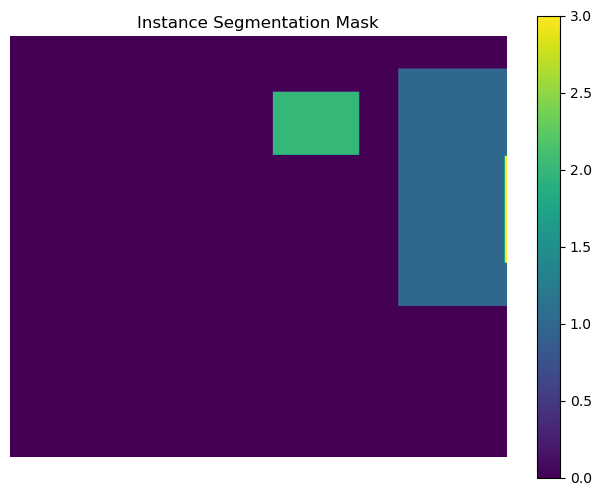

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import json

# Example JSON data
json_data = {
    "90d30949-a733-4e0e-8fdc-b8687e8548ad": {
        "height": 528,
        "width": 622,
        "bbox": [
            {
                "label": "polyp",
                "xmin": 486,
                "ymin": 42,
                "xmax": 622,
                "ymax": 339
            },
            {
                "label": "polyp",
                "xmin": 329,
                "ymin": 71,
                "xmax": 437,
                "ymax": 150
            },
            {
                "label": "polyp",
                "xmin": 619,
                "ymin": 151,
                "xmax": 622,
                "ymax": 285
            }
        ]
    }
}

def create_instance_segmentation_mask(json_data):
    # Extract image dimensions from JSON
    image_id = list(json_data.keys())[0]
    height = json_data[image_id]["height"]
    width = json_data[image_id]["width"]

    # Create empty mask
    instance_mask = np.zeros((height, width), dtype=np.uint8)

    # Draw rectangles for each bounding box
    instance_id = 1
    for bbox in json_data[image_id]["bbox"]:
        xmin, ymin = bbox["xmin"], bbox["ymin"]
        xmax, ymax = bbox["xmax"], bbox["ymax"]
        instance_mask[ymin:ymax, xmin:xmax] = instance_id  # Assign instance ID to the bounding box area
        instance_id += 1

    return instance_mask

# Create instance segmentation mask
instance_segmentation_mask = create_instance_segmentation_mask(json_data)

# Display instance segmentation mask using Matplotlib
plt.figure(figsize=(8, 6))
plt.imshow(instance_segmentation_mask, cmap='viridis')  # Adjust cmap as needed for visualization
plt.colorbar()  # Optional: Add colorbar to show instance IDs
plt.title('Instance Segmentation Mask')
plt.axis('off')  # Optional: Hide axes
plt.show()



# Transform json into instance seg masks
The type of mask you're describing, where there is one background color and multiple colors representing different instances or objects within the image, is typically referred to as a colored instance segmentation mask or color-coded instance segmentation mask.

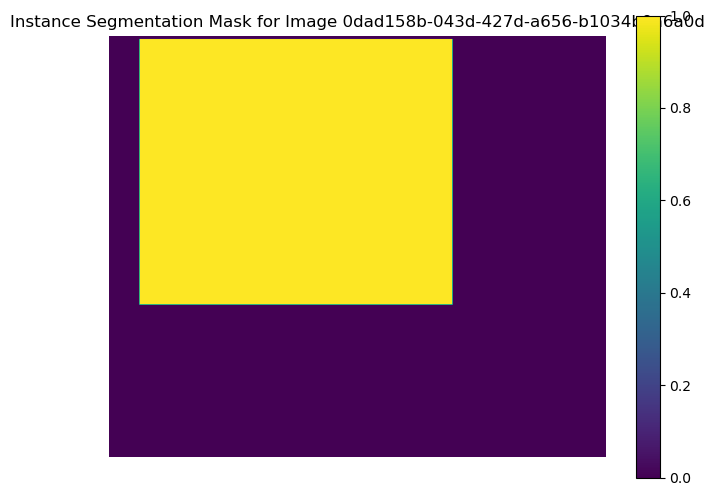

In [59]:
import os
import numpy as np
import matplotlib.pyplot as plt
import json

def create_instance_segmentation_masks(json_data):
    masks = {}

    for image_id, image_info in json_data.items():
        height = image_info["height"]
        width = image_info["width"]
        bbox_list = image_info["bbox"]

        instance_mask = np.zeros((height, width), dtype=np.uint8)

        instance_id = 1
        for bbox in bbox_list:
            xmin, ymin = bbox["xmin"], bbox["ymin"]
            xmax, ymax = bbox["xmax"], bbox["ymax"]
            instance_mask[ymin:ymax, xmin:xmax] = instance_id
            instance_id += 1
        
        masks[image_id] = instance_mask

    return masks

def save_masks(masks, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for image_id, mask in masks.items():
        output_path = os.path.join(output_dir, f'{image_id}_mask.png')
        plt.imsave(output_path, mask, cmap='viridis')  


json_file_path = 'bounding-boxes.json'

output_dir = 'instance_masks'


def load_json_file(json_file):
    with open(json_file, 'r') as f:
        json_data = json.load(f)
    return json_data


json_data = load_json_file(json_file_path)


masks = create_instance_segmentation_masks(json_data)


save_masks(masks, output_dir)


image_id = list(masks.keys())[0] 
plt.figure(figsize=(8, 6))
plt.imshow(masks[image_id], cmap='viridis')  
plt.colorbar()  
plt.title(f'Instance Segmentation Mask for Image {image_id}')
plt.axis('off') 
plt.show()
